# Construction of eulerian comparison dataframe
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

#### Imports

In [2]:
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from filtering import *

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'
path_fields = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/fields_data'

path_save_data = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/eulerian_dataframes'
path_save_plot = '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-06-19_Generate_eulerian_points_dataframe'

In [3]:
def get_mean_datetime(datetime_array):
    # Filter out NaT values
    valid_times = datetime_array[~np.isnat(datetime_array)]

    if valid_times.size > 0:
        # Convert to timedelta in seconds relative to the reference point (e.g., 1970-01-01)
        reference_time = np.datetime64('1970-01-01')
        timedeltas = (valid_times - reference_time).astype('timedelta64[s]').astype(np.float64)

        # Compute the mean of timedeltas
        mean_timedelta = np.mean(timedeltas)

        # Convert mean timedelta back to datetime
        mean_datetime = reference_time + np.timedelta64(int(mean_timedelta), 's')
        return mean_datetime

    else:
        print("No valid datetime values found.")
        return None

## Data and utils

#### field data

In [4]:
def _add_one_Tgrid_velocity(ds, u, axis, padding, replace=True):
    u_t = jpw.tools.operators.interpolation(jnp.copy(ds[u].values), axis=axis, padding=padding)
    if replace:
        ds[u] = ds[u].copy(data=u_t)
    else:
        ds[str(u)+'_t'] = ds[u].copy(data=u_t)
    return ds

def add_Tgrid_velocities(ds, replace=False):

    ds = _add_one_Tgrid_velocity(ds, 'u_geos', axis=1, padding='left', replace=replace)
    ds = _add_one_Tgrid_velocity(ds, 'v_geos', axis=0, padding='left', replace=replace)

    ds = _add_one_Tgrid_velocity(ds, 'u_var', axis=1, padding='left', replace=replace)
    ds = _add_one_Tgrid_velocity(ds, 'v_var', axis=0, padding='left', replace=replace)

    return ds


def interp_velocity_field(ds, u: str, v: str, time_vec, lat_vec, lon_vec):

    #dataframe with interpolation points
    pdf = pd.DataFrame(dict(lat=lat_vec, lon=lon_vec, time=time_vec))

    #add the x,y coords of the interpolation points
    pdf['x'] = np.interp(lon_vec, ds.longitude[0, :], ds.x)
    pdf['y'] = np.interp(lat_vec, ds.latitude[:, 0], ds.y)

    #create indexers DataArrays 
    x_idx = pdf.x.to_xarray()
    y_idx = pdf.y.to_xarray()
    time_idx = pdf.time.to_xarray()

    #xarray interpolate
    interped = ds.interp(x=x_idx, y=y_idx, time=time_idx)

    return interped[u].values, interped[v].values

def restrain_domain(ds, min_lon, max_lon, min_lat, max_lat):
    extend = (min_lon <= ds.longitude) & (ds.longitude <= max_lon) & (min_lat <= ds.latitude) & (ds.latitude <= max_lat)
    in_biscay = (ds.longitude <= -0.1462) & (ds.latitude >= 43.2744)
    in_blacksea = (ds.longitude >= 27.4437) & (ds.latitude >= 40.9088)
    
    mask = extend & ~(in_biscay | in_blacksea) # exclude biscay and black sea
    return ds.where(mask, drop=True)

In [5]:
# MIOST field data

ds_nadir = xr.open_dataset(os.path.join(path_fields, 'field_L4NADIR.nc'))
ds_swot = xr.open_dataset(os.path.join(path_fields, 'field_L4SWOT.nc'))

# add t-grid values for velocities

ds_nadir = add_Tgrid_velocities(ds_nadir, replace=True)
ds_swot  = add_Tgrid_velocities(ds_swot,  replace=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


#### drifters data

In [8]:
def file_selection_mediterranean(files):
    # only mediterranean (not containing 'uwa') 

    selected_files = []
    for file in files:
         if not file.count("uwa"):
            selected_files.append(file)
    return selected_files

def file_selection_by_method(files, method: str):
    # files from one interpolation method: 'variationnal' or 'lowess'

    selected_files = []
    for file in files:
         if file.count(method):
            selected_files.append(file)
    return selected_files

def file_selection_by_sampling(files, sampling: str):
    # files from one smooth L2 sampling: '10min', '30min', '1h' at the end of the file_name

    selected_files = []
    for file in files:
         if file[-11:].count(sampling):
            selected_files.append(file)
    return selected_files


filename convention : L1_type_source_aaaammjj_hhmmss_sampling.format

In [9]:
L2_dir = drifters_directory + '/L2'

mediterranea_files = file_selection_mediterranean(os.listdir(L2_dir))

file_lowess_10min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_10min = file_selection_by_sampling(file_lowess_10min, "10min")

file_lowess_30min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_30min = file_selection_by_sampling(file_lowess_30min, "30min")

file_lowess_1h = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_1h = file_selection_by_sampling(file_lowess_1h, "1h")

In [20]:
file_svp30min = file_selection_by_method(file_lowess_30min, "svp")

['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc']

#### filter

In [10]:
def low_pass_complex(signal, dt, cutoff = 1/(48*3600), order=8 ):

    # filter param
    nyq = 0.5* 1/dt
    normalized_cutoff = cutoff / nyq

    b, a = scipy.signal.butter(order, normalized_cutoff, btype='low', analog=False)

    # low pass and remove mean error
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
  
    return filtered_signal

In [11]:
def gaussian_filter(x, dt, gaussian_width=12*3600):

    # defines gaussian
    gaussian_window_width = 3*gaussian_width
    tt = np.arange(-gaussian_window_width, gaussian_window_width+dt, dt)
    
    gaussian = np.exp(-0.5 * (tt/gaussian_width)**2)
    gaussian = gaussian / np.sum(np.abs(gaussian))
    
    #padd and convolve
    padd = len(gaussian) //2 -1
    x_padded = np.pad(x, padd, mode='symmetric')

    return np.convolve(x_padded, gaussian, 'same')[padd:-padd]

## One trajectory processing
- filter the drifters data from one trajectory
- interpolate the fields data at the filtered positions and times
- return a vaex dataframe with all the information for one point of eulerian comparison

#### func

In [14]:
def init_points_compa():
    return vaex.from_arrays(id   = np.empty(0, dtype= str),
                            time = np.empty(0, dtype=np.datetime64),
                            
                            lat = np.empty(0, dtype=np.float64),
                            lon = np.empty(0, dtype=np.float64),

                            u_drifter = np.empty(0, dtype=np.float64),
                            v_drifter = np.empty(0, dtype=np.float64),

                            u_geo_swot = np.empty(0, dtype=np.float64),
                            v_geo_swot = np.empty(0, dtype=np.float64),

                            u_var_swot = np.empty(0, dtype=np.float64),
                            v_var_swot = np.empty(0, dtype=np.float64),

                            u_geo_nadir = np.empty(0, dtype=np.float64),
                            v_geo_nadir = np.empty(0, dtype=np.float64),

                            u_var_nadir = np.empty(0, dtype=np.float64),
                            v_var_nadir = np.empty(0, dtype=np.float64)

                            )



def process_comparison_one_trajectory(traj: xr.Dataset, vector_spacing: int, mode_lonlat = 'gaussian'):
    '''
    traj: xr.Dataset, 
    trajectory with vars: time, lat, lon, u, v
    
    vector_spacing: int
    spacing between points that are saved

    RETURN: points: vaex.dataframe with index : # id	time	lat	lon	u_drifter	v_drifter	u_geo_swot	v_geo_swot	u_var_swot	v_var_swot	u_geo_nadir	v_geo_nadir	u_var_nadir	v_var_nadir
    '''

    time, lat, lon, u, v = traj.time.values, traj.lat.values, traj.lon.values, traj.u.values, traj.v.values  
    dt = float(traj.time[1] - traj.time[0])*1e-9

    # --- Velocities filtering
    U = u + 1j* v
    U_filtered = low_pass_complex(U, dt=dt)
    
    # take one value each vectorspacing
    time = time[::vector_spacing]
    
    U_filtered = U_filtered[::vector_spacing] 
    u_filtered = U_filtered.real
    v_filtered = U_filtered.imag


    # --- Position filtering
    if mode_lonlat == 'low_pass':
        X = lon + 1j* lat
        X_filtered = low_pass_complex(X, dt=dt)
        X_filtered = X_filtered[::vector_spacing] 

        lon_filtered = X_filtered.real
        lat_filtered = X_filtered.imag
        
    if mode_lonlat == 'gaussian':
        lon_filtered = gaussian_filter(lon, dt=dt)
        lat_filtered = gaussian_filter(lat, dt=dt)

        lon_filtered = lon_filtered[::vector_spacing]
        lat_filtered = lat_filtered[::vector_spacing]


    # --- get field interpolated velocities
    u_geo_swot, v_geo_swot = interp_velocity_field(ds_swot, 'u_geos', 'v_geos', time, lat_filtered, lon_filtered)
    u_var_swot, v_var_swot = interp_velocity_field(ds_swot, 'u_var',  'v_var',  time, lat_filtered, lon_filtered)

    u_geo_nadir, v_geo_nadir = interp_velocity_field(ds_nadir, 'u_geos', 'v_geos', time, lat_filtered, lon_filtered)
    u_var_nadir, v_var_nadir = interp_velocity_field(ds_nadir, 'u_var', 'v_var',   time, lat_filtered, lon_filtered)

    # --- save in the vaex dataframe
    id_array = np.array( [id]*len(time) )
    
    points = vaex.from_arrays(id=id_array, time=time, 
                                lat=lat_filtered, lon=lon_filtered,

                                u_drifter=u_filtered, v_drifter=v_filtered,  

                                u_geo_swot=u_geo_swot, v_geo_swot=v_geo_swot,  
                                u_var_swot=u_var_swot, v_var_swot=v_var_swot,  

                                u_geo_nadir=u_geo_nadir, v_geo_nadir=v_geo_nadir,  
                                u_var_nadir=u_var_nadir, v_var_nadir=v_var_nadir
                            )
    
    return points

#### One trajectory test and visualization

In [15]:
file_lowess_10min

['L2_svp_scripps_10min_lowess_10min_v0.nc',
 'L2_melodi_eodyn_10min_lowess_10min_v0.nc',
 'L2_svp_shom_10min_lowess_10min_v0.nc',
 'L2_spotter_lops_30min_lowess_10min_v0.nc',
 'L2_svp_scripps_1h_lowess_10min_v0.nc',
 'L2_code_ogs_10min_lowess_10min_v0.nc',
 'L2_svp_ogs_10min_lowess_10min_v0.nc',
 'L2_carthe_lops_5min_lowess_10min_v0.nc',
 'L2_svp_ogs_1h_lowess_10min_v0.nc',
 'L2_svp_bcg_10min_lowess_10min_v0.nc',
 'L2_carthe_cnr_5min_lowess_10min_v0.nc']

View one tajectory

/tmp/ipykernel_15243/2871692943.py:38: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  field = field.interp(time=time_ssh)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)


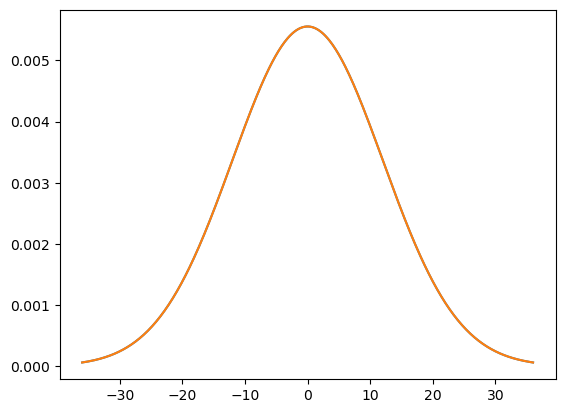

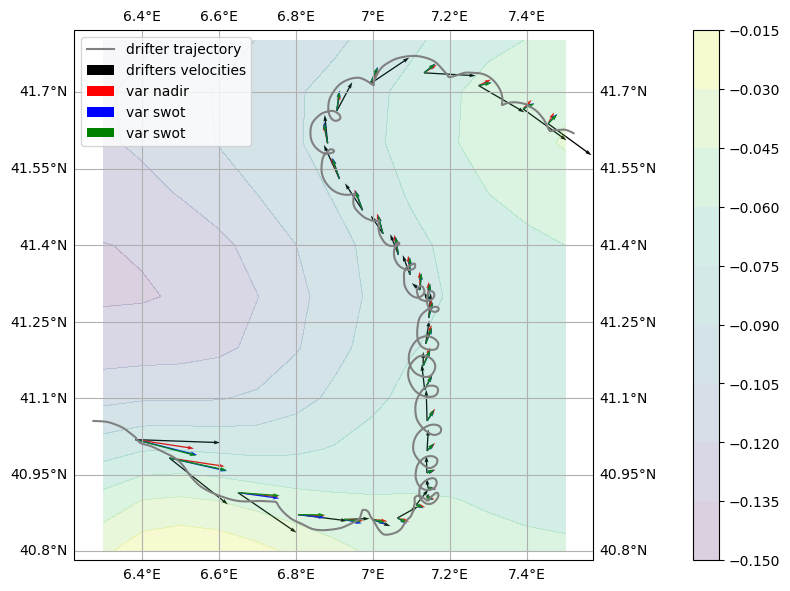

In [12]:
one_trajectory = xr.open_dataset(os.path.join(L2_dir, file_lowess_10min[6])).isel(id=5).dropna(dim='time', how='any', subset=['u'])


points = process_comparison_one_trajectory(one_trajectory, vector_spacing=100, mode_lonlat='gaussian')
# Plot the trajectory with the velocity vectors AND fields vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)
scale=1.5e-5
width=2.5e-3

padd = 0.05
bbox = (np.nanmin(one_trajectory.lon.values) -padd, np.nanmax(one_trajectory.lon.values) +padd, np.nanmin(one_trajectory.lat.values)-padd, np.nanmax(one_trajectory.lat.values)+padd ) 

ax.set_extent(bbox, crs=crs)

# trajectory
ax.plot(one_trajectory.lon, one_trajectory.lat,transform=crs, color='grey', label='drifter trajectory')

# drifters velocity
ax.quiver(points['lon'].values, points['lat'].values, points['u_drifter'].values, points['v_drifter'].values, 
            color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label = 'drifters velocities')

# field velocity
ax.quiver(points['lon'].values, points['lat'].values, points['u_var_nadir'].values, points['v_var_nadir'].values, color='r', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='var nadir')
ax.quiver(points['lon'].values, points['lat'].values, points['u_var_swot'].values, points['v_var_swot'].values, color='b', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='var swot')
ax.quiver(points['lon'].values, points['lat'].values, points['u_geo_swot'].values, points['v_geo_swot'].values, color='g', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='var swot')


# ssh field
time_ssh = get_mean_datetime(one_trajectory.time.values)
#time_ssh = np.nanmax(one_trajectory.time.values)

field = restrain_domain(ds_swot, *bbox)
field = field.interp(time=time_ssh)
ssh_field = ax.contourf(field.longitude, field.latitude, field.ssh, transform=crs, alpha=0.2, label='SSH (swot)')

# Add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1, axes_class=plt.Axes)
cbar = plt.colorbar(ssh_field, cax=cax)


ax.legend()
plt.savefig(os.path.join(path_save_plot, 'filtreddrifter_field_comparison.png'), bbox_inches='tight', dpi = 300)

See multiple trajectories

/tmp/ipykernel_17363/3489398655.py:44: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  field = field.interp(time=time_ssh)
/tmp/ipykernel_17363/3489398655.py:44: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond p

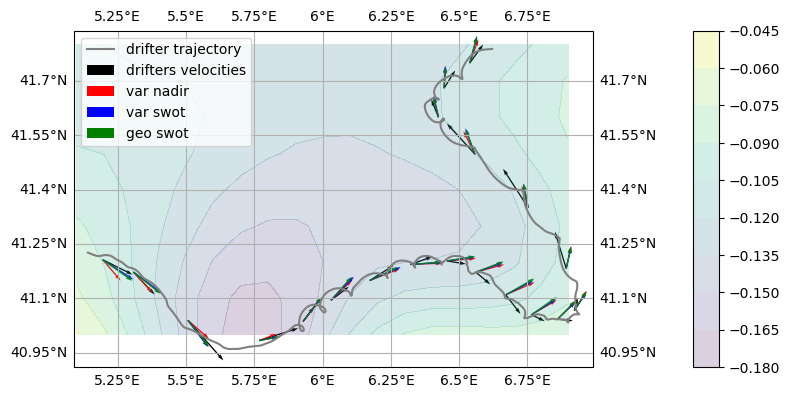

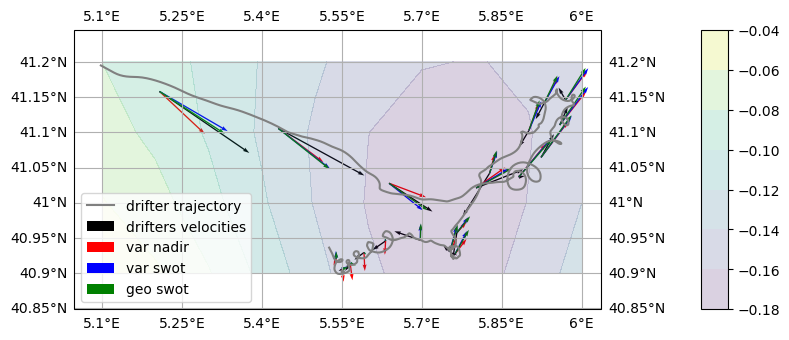

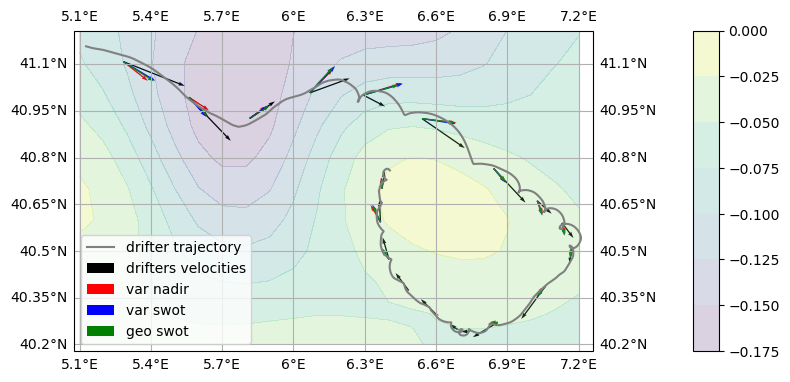

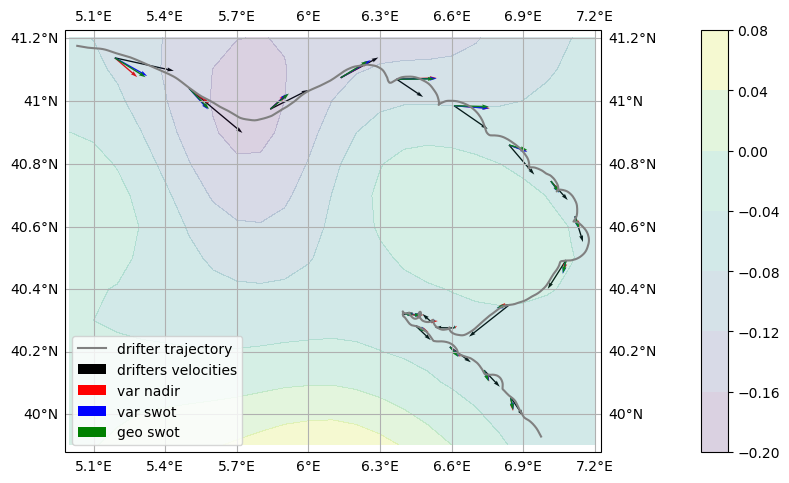

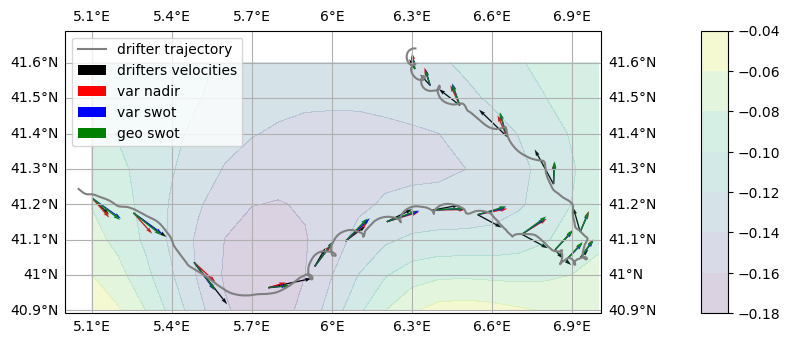

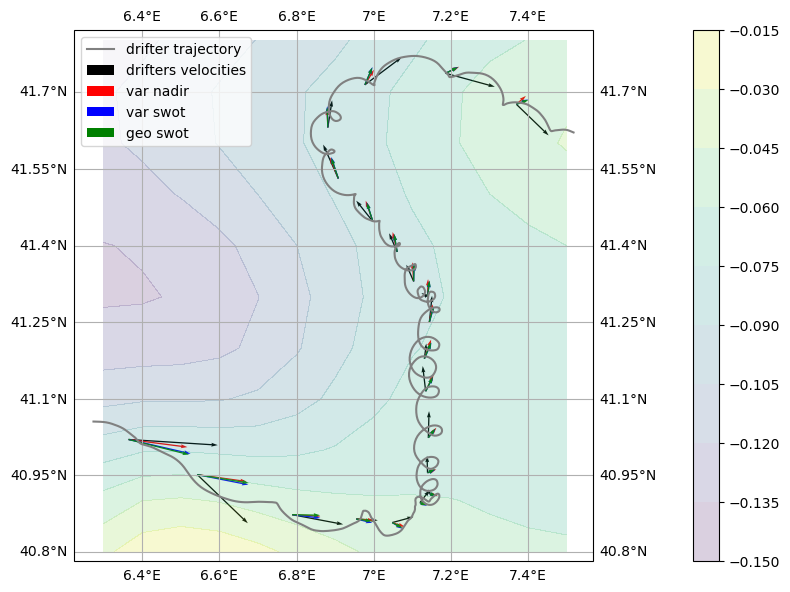

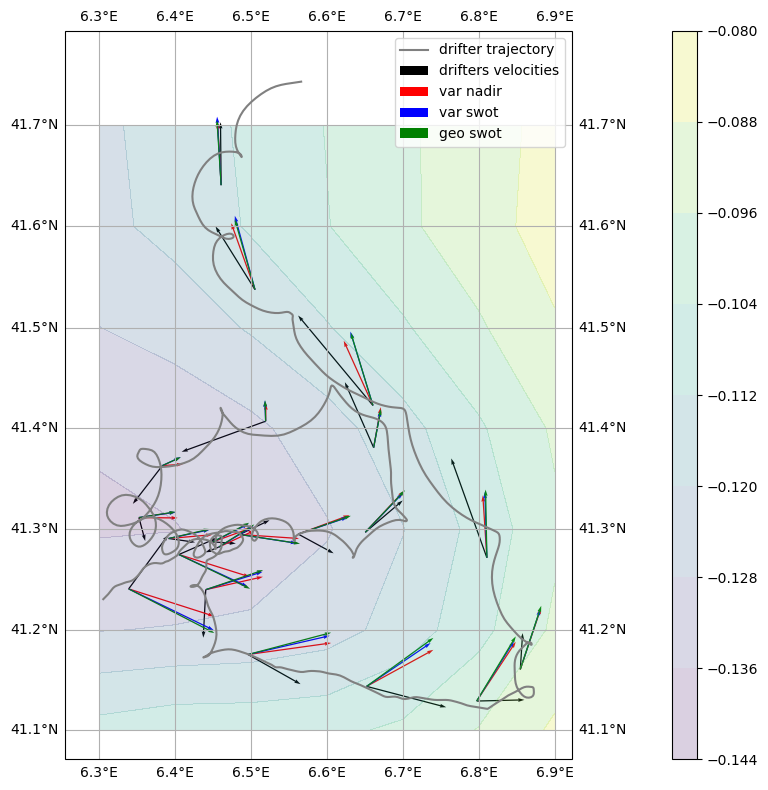

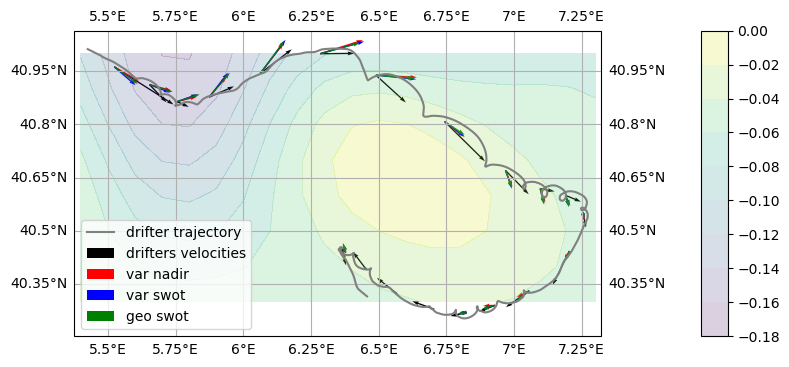

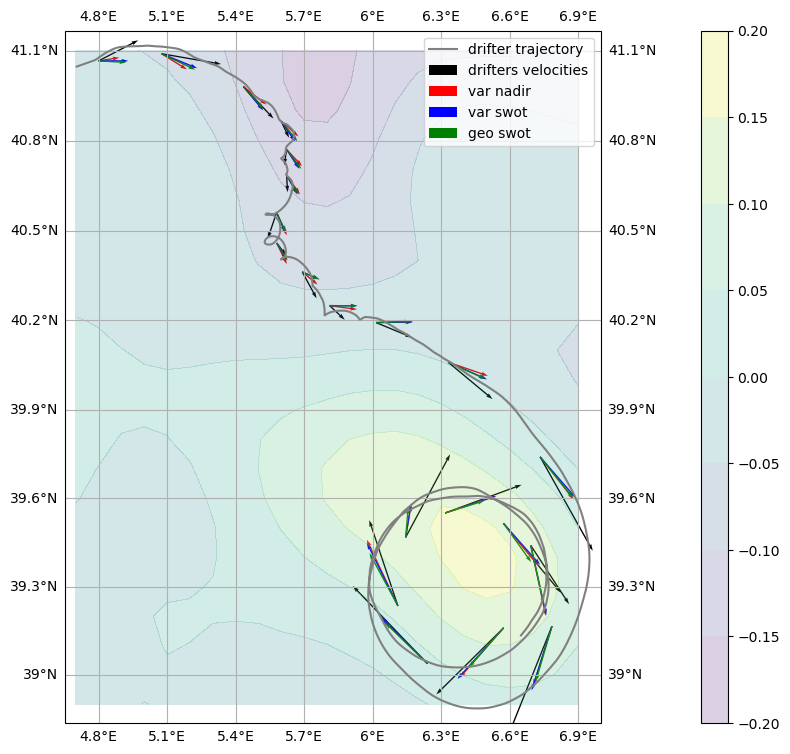

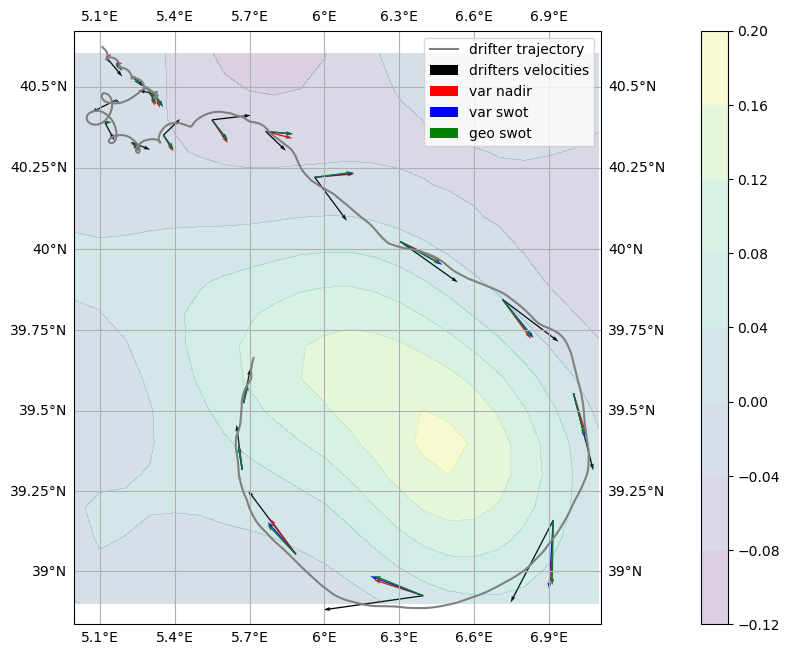

In [120]:
###############

files = file_lowess_30min
sample = '30min'
file_n = 3
save = False

################

ds = xr.open_dataset(os.path.join(L2_dir, files[file_n]))

for id in range(len(ds.id.values)):
    one_trajectory = ds.isel(id=id).dropna(dim='time', how='any', subset=['u'])

    points = process_comparison_one_trajectory(one_trajectory, vector_spacing=48, mode_lonlat='gaussian')
    # Plot the trajectory with the velocity vectors AND fields vectors

    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    gl = ax.gridlines(draw_labels=True,)
    ax.add_feature(cfeature.LAND,)
    scale=1.5e-5
    width=2.5e-3

    padd = 0.05
    bbox = (np.nanmin(one_trajectory.lon.values) -padd, np.nanmax(one_trajectory.lon.values) +padd, np.nanmin(one_trajectory.lat.values)-padd, np.nanmax(one_trajectory.lat.values)+padd ) 

    ax.set_extent(bbox, crs=crs)

    # trajectory
    ax.plot(one_trajectory.lon, one_trajectory.lat,transform=crs, color='grey', label='drifter trajectory')

    # drifters velocity
    ax.quiver(points['lon'].values, points['lat'].values, points['u_drifter'].values, points['v_drifter'].values, 
                color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label = 'drifters velocities')

    # field velocity
    ax.quiver(points['lon'].values, points['lat'].values, points['u_var_nadir'].values, points['v_var_nadir'].values, color='r', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='var nadir')
    ax.quiver(points['lon'].values, points['lat'].values, points['u_var_swot'].values, points['v_var_swot'].values, color='b', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='var swot')
    ax.quiver(points['lon'].values, points['lat'].values, points['u_geo_swot'].values, points['v_geo_swot'].values, color='g', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='geo swot')


    # ssh field
    time_ssh = get_mean_datetime(one_trajectory.time.values)
    #time_ssh = np.nanmax(one_trajectory.time.values)

    field = restrain_domain(ds_swot, *bbox)
    field = field.interp(time=time_ssh)
    ssh_field = ax.contourf(field.longitude, field.latitude, field.ssh, transform=crs, alpha=0.2)
    
    # Add colorbar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=1, axes_class=plt.Axes)
    cbar = plt.colorbar(ssh_field, cax=cax)


    ax.legend()
    if save: 
        plt.savefig(os.path.join(path_save_plot, 'filtreddrifter_field_comparison_file_lowess_{}_file {} and id {}.png'.format(sample, file_n, id)), bbox_inches='tight', dpi = 300)

## Create dataframe for several files

In [24]:

### CONVERT A FOLDER OF FILES INTO ONE POINTS COMPARISON DATAFRAME

files     = file_svp30min  #file_lowess_30min
save_name = 'L4_and_lowess_30min_vs01_final_filter_SVPonly'

vector_spacing = 1

# add points for each processed trajectory
points_compa = init_points_compa()
for file_number, file in enumerate(files):
    
    ds = xr.open_dataset(os.path.join(L2_dir, file))

    for i, id in enumerate(ds.id.values):
        print('processing file {} / {} ; id {} / {}'.format(file_number, len(file_lowess_1h)-1, i, ds.sizes['id']-1))
        
        traj = ds.sel(id=id).dropna(dim='time', how='any', subset=['u'])
        span_drifters_days = float(np.nanmax(traj.time) - np.nanmin(traj.time))/1e9/(24*3600)

        if span_drifters_days > 6: # remove too small trajectories
            points = process_comparison_one_trajectory(traj, vector_spacing, mode_lonlat = 'gaussian')
            points_compa = vaex.concat([points_compa, points])
        else:
            print('the trajectory is too small')

# export to hdf5
points_compa.export_hdf5(os.path.join(path_save_data, save_name+'.hdf5'))

processing file 0 / 10 ; id 0 / 7
processing file 0 / 10 ; id 1 / 7
processing file 0 / 10 ; id 2 / 7
processing file 0 / 10 ; id 3 / 7
processing file 0 / 10 ; id 4 / 7
processing file 0 / 10 ; id 5 / 7
processing file 0 / 10 ; id 6 / 7
processing file 0 / 10 ; id 7 / 7
processing file 1 / 10 ; id 0 / 9
processing file 1 / 10 ; id 1 / 9
processing file 1 / 10 ; id 2 / 9
processing file 1 / 10 ; id 3 / 9
processing file 1 / 10 ; id 4 / 9
processing file 1 / 10 ; id 5 / 9
processing file 1 / 10 ; id 6 / 9
processing file 1 / 10 ; id 7 / 9
processing file 1 / 10 ; id 8 / 9
processing file 1 / 10 ; id 9 / 9
processing file 2 / 10 ; id 0 / 9
processing file 2 / 10 ; id 1 / 9
processing file 2 / 10 ; id 2 / 9
processing file 2 / 10 ; id 3 / 9
processing file 2 / 10 ; id 4 / 9
processing file 2 / 10 ; id 5 / 9
processing file 2 / 10 ; id 6 / 9
processing file 2 / 10 ; id 7 / 9
processing file 2 / 10 ; id 8 / 9
processing file 2 / 10 ; id 9 / 9
processing file 3 / 10 ; id 0 / 27
processing fi